In [1]:
from scripts.data_load import load_and_link_all_data
from scripts.data_curate import create_ml_feature_set

# Load and Process Data:

In [2]:
ml_dataset, matches, player_matches = load_and_link_all_data(base_path="data/2024-2025")

print(f"\nFinal ML dataset shape: {ml_dataset.shape}")
print(f"Columns available: {len(ml_dataset.columns)}")

Loading base datasets...

Loading match data across all gameweeks...
Loaded 389 matches and 11210 player-match records

Linking datasets...

Final ML dataset shape: (27231, 97)
Columns available: 97


In [3]:
print(ml_dataset.shape)
ml_dataset.head(3)


(27231, 97)


,element,gameweek,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,expected_goal_involvements,...,home_score,away_score,team_id,player_id_master,player_code,modified,was_home,name,team,position
0,1,1,2.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,1.0,438098.0,False,True,Fábio Ferreira Vieira,Arsenal,MID
1,1,2,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,1.0,438098.0,False,False,Fábio Ferreira Vieira,Arsenal,MID
2,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,1.0,438098.0,False,True,Fábio Ferreira Vieira,Arsenal,MID


# Curate Data for ML Modeling:

In [4]:
ml_feature_set = create_ml_feature_set(ml_dataset)
print(ml_feature_set.shape)
ml_feature_set.head(3)

(27231, 196)


element,gameweek,total_points,transfers_balance,transfers_in,transfers_out,value,name,team,position,assists_last5,assists_last3,assists_last1,bps_last5,bps_last3,bps_last1,clean_sheets_last5,clean_sheets_last3,clean_sheets_last1,creativity_last5,creativity_last3,creativity_last1,threat_last5,threat_last3,threat_last1,expected_assists_last5,expected_assists_last3,expected_assists_last1,expected_goal_involvements_last5,expected_goal_involvements_last3,expected_goal_involvements_last1,expected_goals_last5,expected_goals_last3,expected_goals_last1,expected_goals_conceded_last5,expected_goals_conceded_last3,expected_goals_conceded_last1,…,gk_accurate_long_balls_last1,gk_accurate_passes_last5,gk_accurate_passes_last3,gk_accurate_passes_last1,offsides_last5,offsides_last3,offsides_last1,penalties_saved_last5,penalties_saved_last3,penalties_saved_last1,chances_created_last5,chances_created_last3,chances_created_last1,team_goals_last5,team_goals_last3,team_goals_last1,team_conceded_last5,team_conceded_last3,team_conceded_last1,goal_difference_last5,goal_difference_last3,goal_difference_last1,clean_sheet_last5,clean_sheet_last3,clean_sheet_last1,team_won_last5,team_won_last3,team_won_last1,team_drew_last5,team_drew_last3,team_drew_last1,team_lost_last5,team_lost_last3,team_lost_last1,total_points_last5,total_points_last3,total_points_last1
i64,i64,i64,f64,f64,f64,f64,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
1,1,0,0.0,0.0,0.0,55.0,"""Fábio Ferreira Vieira""","""Arsenal""",3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2,0,-790.0,84.0,874.0,55.0,"""Fábio Ferreira Vieira""","""Arsenal""",3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,3,0,-279.0,355.0,634.0,54.0,"""Fábio Ferreira Vieira""","""Arsenal""",3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
# Other features that I want to retain but don't want to use for modeling
# These are features that are useful for analysis but not for modeling
exl_feats = [
    'element', 'gameweek', 'total_points', 'name', 'team'
    'transfers_balance', 'transfers_in', 'transfers_out', 'value', 
]

In [6]:
from scripts.viz import plot_player_cumulative_points

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Andreas Hoelgebaum Pereira - Fulham (MID)\nFPL Points Progress 2024-25'}, xlabel='Gameweek', ylabel='Cumulative Points'>)

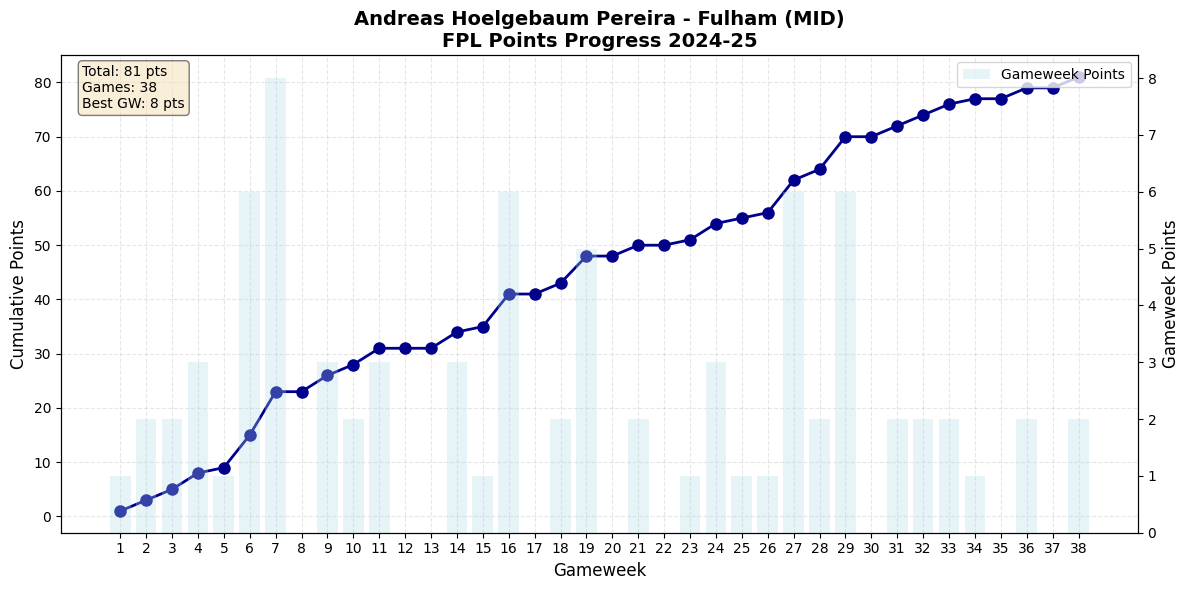

In [ ]:
# example to show that data is being aggregated correctly
plot_player_cumulative_points(ml_feature_set, player_id=240, figsize=(12, 6))

In [8]:
from scripts.model import FPLPointPredictor
import polars as pl

In [9]:
max_gw = ml_feature_set['gameweek'].max()
train_set = ml_feature_set.filter(
                    (pl.col('gameweek') < 38) & 
                    (pl.col('gameweek') > 1)
                )
current_gw = ml_feature_set.filter(pl.col('gameweek') == max_gw)

print(f"Training set shape: {train_set.shape}")
print(f"Current gameweek shape: {current_gw.shape}")

Training set shape: (25811, 196)
Current gameweek shape: (804, 196)


In [ ]:
print("\nTraining model...")
predictor = FPLPointPredictor(use_xgboost=True, 
                              analysis_cols=['element', 'gameweek', 'name', 'team'],
                              target_col='total_points',
                              )


Training model...


In [18]:
predictor.train(train_set)

Fold 1: Training up to GW 37, validating on GW 2+
Fold 2: Training up to GW 37, validating on GW 2+
Fold 3: Training up to GW 37, validating on GW 2+
Fold 4: Training up to GW 37, validating on GW 2+
Fold 5: Training up to GW 37, validating on GW 2+

Top 10 most important features:
shape: (10, 2)
┌─────────────────────────────────┬────────────┐
│ feature                         ┆ importance │
│ ---                             ┆ ---        │
│ str                             ┆ f64        │
╞═════════════════════════════════╪════════════╡
│ minutes_last1                   ┆ 0.218346   │
│ transfers_in                    ┆ 0.068671   │
│ minutes_last3                   ┆ 0.049209   │
│ value                           ┆ 0.032161   │
│ transfers_balance               ┆ 0.020095   │
│ transfers_out                   ┆ 0.016508   │
│ expected_goals_conceded_last1   ┆ 0.014574   │
│ expected_goal_involvements_las… ┆ 0.011422   │
│ bps_last1                       ┆ 0.010621   │
│ expected_goals

[{'mae': 1.1699150380097858, 'r2': 0.2533056556905612},
 {'mae': 1.3345497921736258, 'r2': 0.21394913907645718},
 {'mae': 1.0516822706668973, 'r2': 0.3130785155847873},
 {'mae': 1.0283614764227893, 'r2': 0.27418256218872294},
 {'mae': 0.8500363575955906, 'r2': 0.13441323146869566}]

In [20]:
pred_df = predictor.predict_next_gameweek(current_gw)

In [16]:
top_picks = predictor.get_top_picks(pred_df, n_per_position=10, sort_by='predicted_points')
print(top_picks)

{'GKP': shape: (10, 6)
┌─────────────────────┬────────────────┬───────┬──────────────────┬─────────────────┬──────────────┐
│ name                ┆ team           ┆ value ┆ predicted_points ┆ predicted_value ┆ total_points │
│ ---                 ┆ ---            ┆ ---   ┆ ---              ┆ ---             ┆ ---          │
│ str                 ┆ str            ┆ f64   ┆ f32              ┆ f64             ┆ i64          │
╞═════════════════════╪════════════════╪═══════╪══════════════════╪═════════════════╪══════════════╡
│ Nick Pope           ┆ Newcastle      ┆ 50.0  ┆ 3.795757         ┆ 0.759151        ┆ 3            │
│ Kepa Arrizabalaga   ┆ Bournemouth    ┆ 46.0  ┆ 3.66658          ┆ 0.797083        ┆ 6            │
│ David Raya Martin   ┆ Arsenal        ┆ 56.0  ┆ 3.464769         ┆ 0.618709        ┆ 2            │
│ Dean Henderson      ┆ Crystal Palace ┆ 46.0  ┆ 3.408534         ┆ 0.740986        ┆ 2            │
│ Matz Sels           ┆ Nott'm Forest  ┆ 52.0  ┆ 3.330624         ┆ 

In [21]:
top_picks = predictor.get_top_picks(pred_df, n_per_position=10, sort_by='predicted_points')
print(top_picks)

{'GKP': shape: (10, 6)
┌─────────────────────┬────────────────┬───────┬──────────────────┬─────────────────┬──────────────┐
│ name                ┆ team           ┆ value ┆ predicted_points ┆ predicted_value ┆ total_points │
│ ---                 ┆ ---            ┆ ---   ┆ ---              ┆ ---             ┆ ---          │
│ str                 ┆ str            ┆ f64   ┆ f64              ┆ f64             ┆ i64          │
╞═════════════════════╪════════════════╪═══════╪══════════════════╪═════════════════╪══════════════╡
│ Alex Palmer         ┆ Ipswich        ┆ 45.0  ┆ 4.241876         ┆ 0.942639        ┆ 0            │
│ David Raya Martin   ┆ Arsenal        ┆ 56.0  ┆ 4.083634         ┆ 0.72922         ┆ 2            │
│ Mark Flekken        ┆ Brentford      ┆ 45.0  ┆ 3.755337         ┆ 0.834519        ┆ 3            │
│ Nick Pope           ┆ Newcastle      ┆ 50.0  ┆ 3.708858         ┆ 0.741772        ┆ 3            │
│ Emiliano Martínez   ┆ Aston Villa    ┆ 50.0  ┆ 3.630286         ┆ 